In [2]:
!pip install matplotlib


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 536.9 kB/s eta 0:00:15
   -- ------------------------------------- 0.5/8.1 MB 536.9 kB/s eta 0:00:15
   -- ------------------------------------- 0.5/8.1 MB 536.9 kB/s eta 0:00:15
   -- ------------------------------------- 0.5/8.1 MB 536.9 kB/s eta 0:00:15
   -- ------------------------------------- 0.5/8.1 MB 536.9 kB/s eta 0:00:15
   -- ------------------------------------- 0.5/8.1 MB 536.9 kB/s eta 0:00:15
   -- ------------------------------------- 0.5/8.1 MB 536.9 kB/s eta 0:00:15
   --- ---------------------------------

In [4]:
!pip install seaborn



In [5]:
import os
import unicodedata
import pandas as pd
import numpy as np
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
#Config/path 
LANG_CSV = r"C:\Users\User PC\Documents\Emmotional AI\language_data.csv"   # your uploaded file
EMO_CSV  = r"C:\Users\User PC\Documents\Emmotional AI\emotion_data.csv"
MODELS_DIR = r"C:\Users\User PC\Documents\Emmotional AI\models"
os.makedirs(MODELS_DIR, exist_ok=True)

In [10]:
# 2. SMALL PREPROCESSING
# (do NOT strip diacritics — these languages use them)
# we'll normalize unicode and trim whitespace only
# ---------------------------
def normalize_text(s):
    if pd.isna(s):
        return ""
    s = str(s).strip()
    s = unicodedata.normalize("NFKC", s)   # keeps diacritics intact, canonical form
    return s


In [11]:
# 3. LOAD DATA
# Expect columns 'text' and 'label'
# ---------------------------
lang_df = pd.read_csv(LANG_CSV)
emo_df  = pd.read_csv(EMO_CSV)

# basic checks
assert 'text' in lang_df.columns and 'label' in lang_df.columns, "language CSV must have text,label columns"
assert 'text' in emo_df.columns  and 'label' in emo_df.columns, "emotion CSV must have text,label columns"

lang_df['text'] = lang_df['text'].apply(normalize_text)
emo_df['text']  = emo_df['text'].apply(normalize_text)

In [12]:
# ---------------------------
# 4. TRAIN/VALIDATION SPLITS
# Stratify to keep label balance (your files are balanced)
# ---------------------------
lang_X = lang_df['text'].values
lang_y = lang_df['label'].values

emo_X = emo_df['text'].values
emo_y = emo_df['label'].values

lang_X_train, lang_X_test, lang_y_train, lang_y_test = train_test_split(
    lang_X, lang_y, test_size=0.2, random_state=42, stratify=lang_y
)

emo_X_train, emo_X_test, emo_y_train, emo_y_test = train_test_split(
    emo_X, emo_y, test_size=0.2, random_state=42, stratify=emo_y
)

In [13]:
# ---------------------------
# 5. BUILD PIPELINES (TF-IDF + LogisticRegression)
# - For language detection: char n-grams often work best on short multilingual sentences.
# - For emotion detection: word n-grams + TF-IDF is commonly effective.
# ---------------------------
lang_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char_wb", ngram_range=(2,5), min_df=1)),
    ("clf", LogisticRegression(solver="liblinear", max_iter=2000))
])

emo_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="word", ngram_range=(1,2), min_df=1)),
    ("clf", LogisticRegression(solver="liblinear", multi_class="ovr", max_iter=2000))
])


In [14]:
# ---------------------------
# 6. TRAIN
# ---------------------------
print("Training language model...")
lang_pipeline.fit(lang_X_train, lang_y_train)

print("Training emotion model...")
emo_pipeline.fit(emo_X_train, emo_y_train)


Training language model...
Training emotion model...


C:\Users\User PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\User PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\User PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver whic

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None



=== Language detector — accuracy: 1.000 ===
              precision    recall  f1-score   support

       Hausa       1.00      1.00      1.00         4
        Igbo       1.00      1.00      1.00         4
      Yoruba       1.00      1.00      1.00         5

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



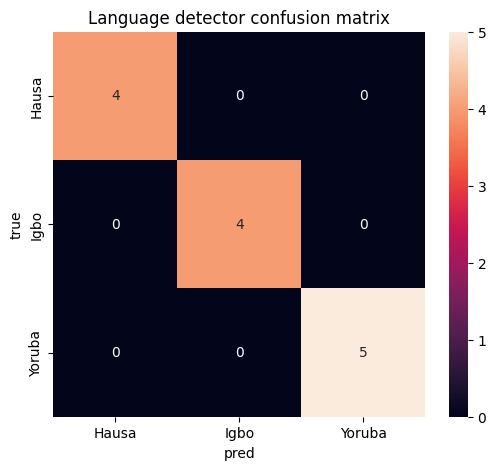


=== Emotion detector — accuracy: 0.231 ===
              precision    recall  f1-score   support

       Angry       0.17      1.00      0.29         1
        Fear       0.00      0.00      0.00         2
       Happy       0.00      0.00      0.00         2
        Love       0.00      0.00      0.00         2
     Neutral       0.00      0.00      0.00         2
         Sad       0.00      0.00      0.00         2
    Surprise       0.67      1.00      0.80         2

    accuracy                           0.23        13
   macro avg       0.12      0.29      0.16        13
weighted avg       0.12      0.23      0.15        13



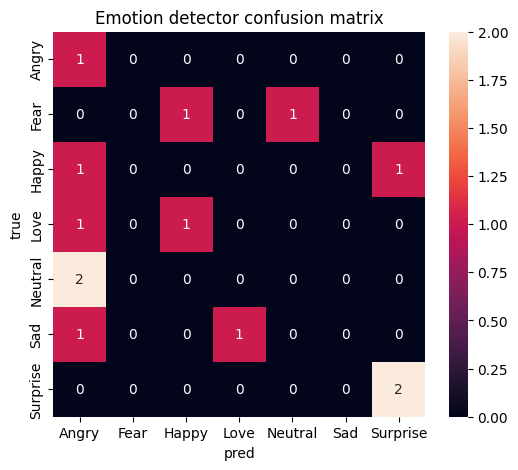

In [15]:
# ---------------------------
# 7. EVALUATE (test sets)
# ---------------------------
def eval_pipeline(pipe, X_test, y_test, title="Model"):
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {title} — accuracy: {acc:.3f} ===")
    print(classification_report(y_test, y_pred, zero_division=0))
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=pipe.classes_, yticklabels=pipe.classes_)
    plt.title(f"{title} confusion matrix")
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.show()

eval_pipeline(lang_pipeline, lang_X_test, lang_y_test, title="Language detector")
eval_pipeline(emo_pipeline, emo_X_test, emo_y_test, title="Emotion detector")


In [16]:
# 8. SAVE MODELS
# ---------------------------
joblib.dump(lang_pipeline, os.path.join(MODELS_DIR, "lang_pipeline.joblib"))
joblib.dump(emo_pipeline, os.path.join(MODELS_DIR, "emo_pipeline.joblib"))
print("Saved pipelines to", MODELS_DIR)


Saved pipelines to C:\Users\User PC\Documents\Emmotional AI\models


In [19]:
# ---------------------------
# 9. INFERENCE FUNCTION (language -> emotion -> response)
# ---------------------------
# load models (shows how you would use saved models)
lang_pipe = joblib.load(os.path.join(MODELS_DIR, "lang_pipeline.joblib"))
emo_pipe = joblib.load(os.path.join(MODELS_DIR, "emo_pipeline.joblib"))

# simple response map (expand as needed)
RESPONSE_MAP = {
    "Yoruba": {
        "Happy":   "Inu mi dun pe o n rẹrin!",
        "Sad":     "Má bà a ní lokan, ohun gbogbo máa dáa.",
        "Angry":   "Jọwọ, gbiyanju lati tú ọkan rẹ soke — a le sọrọ.",
        "Fear":    "Má ṣe yọ ara rẹ lẹnu, emi wà n'íbẹ̀ fún ọ.",
        "Love":    "O ṣeun, inu mi dun.",
        "Surprise":"Oh! Iyanu ni yẹn!",
        "Neutral": "O ṣeun, mo ti gbọ́ ọ."
    },
    "Hausa": {
        "Happy":   "Ina farin ciki da jin haka!",
        "Sad":     "Ina tausaya maka, za mu iya magana idan kana so.",
        "Angry":   "Ka kwantar da hankalinka; muna iya tattauna shi.",
        "Fear":    "Kar ka ji tsoro, zan taimaka in dai zan iya.",
        "Love":    "Na gode — hakan ya faranta min rai.",
        "Surprise":"Abin mamaki ne!",
        "Neutral": "Na gode, na fahimta."
    },
    "Igbo": {
        "Happy":   "Obi dị m ụtọ ịnụ nke ahụ!",
        "Sad":     "Ekwela ka obi daa gi, ihe niile ga-adịrị mma.",
        "Angry":   "Kwusi iwe—ka anyị kwurịta ya nwayọọ.",
        "Fear":    "Ejila egwu jide gị, m nọ ebe a.",
        "Love":    "Ekele m, nke ahụ gbaara m obi umeala.",
        "Surprise":"Nnọọ! Nke ahụ juputara m n'ịtụnanya.",
        "Neutral": "Daalụ, ewezuga nke ahụ."
    }
}

DEFAULT_REPLY = "Thanks — I'm here for you."

def classify_and_respond(text, lang_pipe=lang_pipe, emo_pipe=emo_pipe, threshold=0.6):
    t = normalize_text(text)
      # predict language
    lang_probs = lang_pipe.predict_proba([t])[0]
    lang_idx = np.argmax(lang_probs)
    lang_label = lang_pipe.classes_[lang_idx]
    lang_conf = float(lang_probs[lang_idx])
    
    # emotion
    # predict emotion
    emo_probs = emo_pipe.predict_proba([t])[0]
    emo_idx = np.argmax(emo_probs)
    emo_label = emo_pipe.classes_[emo_idx]
    emo_conf = float(emo_probs[emo_idx])

    # choose response (if we have mapping)
    response = DEFAULT_REPLY
    if lang_label in RESPONSE_MAP and emo_label in RESPONSE_MAP[lang_label]:
        response = RESPONSE_MAP[lang_label][emo_label]
    elif lang_label != "Unknown":
        # fallback to language-only neutral reply
        response = RESPONSE_MAP.get(lang_label, {}).get("Neutral", DEFAULT_REPLY)

    return {
        "text": text,
        "language": lang_label,
        "language_confidence": float(lang_conf),
        "emotion": emo_label,
        "emotion_confidence": float(emo_conf),
        "response": response
    }


In [20]:
# ---------------------------
# 10. QUICK TESTS
# ---------------------------
tests = [
    "Ina jin dadi sosai",      # Hausa - Happy
    "Ẹ ku ayọ̀",               # Yoruba - Happy
    "E nwere m egwu",          # Igbo - Fear
    "Ina jin haushi sosai",    # Hausa - Angry
    "Mo bínú gan",             # Yoruba - Angry
]

for t in tests:
    out = classify_and_respond(t)
    print(out)

{'text': 'Ina jin dadi sosai', 'language': 'Hausa', 'language_confidence': 0.5723385978848743, 'emotion': 'Angry', 'emotion_confidence': 0.19329227124142406, 'response': 'Ka kwantar da hankalinka; muna iya tattauna shi.'}
{'text': 'Ẹ ku ayọ̀', 'language': 'Yoruba', 'language_confidence': 0.4066744788295323, 'emotion': 'Angry', 'emotion_confidence': 0.1549701212919148, 'response': 'Jọwọ, gbiyanju lati tú ọkan rẹ soke — a le sọrọ.'}
{'text': 'E nwere m egwu', 'language': 'Igbo', 'language_confidence': 0.4774341649428546, 'emotion': 'Fear', 'emotion_confidence': 0.2597716757038351, 'response': 'Ejila egwu jide gị, m nọ ebe a.'}
{'text': 'Ina jin haushi sosai', 'language': 'Hausa', 'language_confidence': 0.56934890938289, 'emotion': 'Angry', 'emotion_confidence': 0.23728305314682677, 'response': 'Ka kwantar da hankalinka; muna iya tattauna shi.'}
{'text': 'Mo bínú gan', 'language': 'Yoruba', 'language_confidence': 0.5105167162439033, 'emotion': 'Angry', 'emotion_confidence': 0.159033413924

In [21]:
# ---------------------------
# 12. MINI CHAT LOOP
# ---------------------------
print("\n🗣️  Multilingual Emotion Chatbot")
print("Type a message in Yoruba, Hausa, or Igbo (or 'quit' to exit).")
print("-------------------------------------------------------------")

while True:
    user_input = input("You: ").strip()
    if user_input.lower() in ["quit", "exit", "bye"]:
        print("Bot: Bye 👋, have a nice day!")
        break

    result = classify_and_respond(user_input)

    print(f"→ Language: {result['language']} ({result['language_confidence']:.2f})")
    print(f"→ Emotion:  {result['emotion']} ({result['emotion_confidence']:.2f})")
    print(f"Bot: {result['response']}")
    print("-------------------------------------------------------------")



🗣️  Multilingual Emotion Chatbot
Type a message in Yoruba, Hausa, or Igbo (or 'quit' to exit).
-------------------------------------------------------------


You:  Boo ni


→ Language: Yoruba (0.42)
→ Emotion:  Neutral (0.17)
Bot: O ṣeun, mo ti gbọ́ ọ.
-------------------------------------------------------------


You:  inu mi o dun


→ Language: Yoruba (0.53)
→ Emotion:  Angry (0.18)
Bot: Jọwọ, gbiyanju lati tú ọkan rẹ soke — a le sọrọ.
-------------------------------------------------------------


You:  nagode


→ Language: Igbo (0.38)
→ Emotion:  Angry (0.15)
Bot: Kwusi iwe—ka anyị kwurịta ya nwayọọ.
-------------------------------------------------------------


You:  ebi n pami


→ Language: Yoruba (0.41)
→ Emotion:  Angry (0.15)
Bot: Jọwọ, gbiyanju lati tú ọkan rẹ soke — a le sọrọ.
-------------------------------------------------------------


You:  mo fe jade


→ Language: Yoruba (0.46)
→ Emotion:  Angry (0.17)
Bot: Jọwọ, gbiyanju lati tú ọkan rẹ soke — a le sọrọ.
-------------------------------------------------------------


You:  lo sun


→ Language: Yoruba (0.39)
→ Emotion:  Angry (0.15)
Bot: Jọwọ, gbiyanju lati tú ọkan rẹ soke — a le sọrọ.
-------------------------------------------------------------


You:  rerin


→ Language: Hausa (0.37)
→ Emotion:  Angry (0.15)
Bot: Ka kwantar da hankalinka; muna iya tattauna shi.
-------------------------------------------------------------


You:  mi o mo


→ Language: Yoruba (0.59)
→ Emotion:  Angry (0.18)
Bot: Jọwọ, gbiyanju lati tú ọkan rẹ soke — a le sọrọ.
-------------------------------------------------------------


You:  mo nbo


→ Language: Yoruba (0.57)
→ Emotion:  Angry (0.17)
Bot: Jọwọ, gbiyanju lati tú ọkan rẹ soke — a le sọrọ.
-------------------------------------------------------------


You:  Okan mi fẹran rẹ


→ Language: Yoruba (0.56)
→ Emotion:  Love (0.24)
Bot: O ṣeun, inu mi dun.
-------------------------------------------------------------


You:  ife re


→ Language: Igbo (0.38)
→ Emotion:  Angry (0.15)
Bot: Kwusi iwe—ka anyị kwurịta ya nwayọọ.
-------------------------------------------------------------


You:  Boo ni


→ Language: Yoruba (0.42)
→ Emotion:  Neutral (0.17)
Bot: O ṣeun, mo ti gbọ́ ọ.
-------------------------------------------------------------


You:  quit


Bot: Bye 👋, have a nice day!
